# Section 1: Load preprocessed data

In [1]:
# Libraries
import os
import pandas as pd
import numpy as np
from datetime import datetime

# Plotting libraries
import plotly.express as px
import plotly.graph_objects as go 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker

In [2]:
# Reload datasets
dir_path = "../dataset/divvy/"

def reload_data():
    
    if "geocode.csv" in os.listdir(dir_path):
        geocode = pd.read_csv(dir_path + "geocode.csv")
    else:
        geocode = None
        print("geocode.csv not available.")
        pass

    if "df2.csv" in os.listdir(dir_path):
        df = pd.read_csv(dir_path + "df2.csv")
    else:
        df = None
        print("merged dataset df2.csv not available.")
        pass
        
    return geocode, df

geocode, df = reload_data()

In [3]:
# Cleaning data for exploratory data analysis
df["tripduration"] = df["tripduration"].apply(lambda x: int(x.split(".")[0].replace(",","")))
df["age"] = df["birthyear"].apply(lambda x: 2019 - int(x))
df["age_group"] = pd.cut(df["age"], [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
df["usertype"] = pd.Categorical(df["usertype"], categories=["Subscriber", "Customer"])      # reduce memory space
df["gender"] = pd.Categorical(df["gender"], categories=["Female", "Male"])

df.drop(["birthyear"], axis=1, inplace=True)

# Identify the trip directions based on from_station_name and to_station_name
trip_list = []

for start, end in zip(df["from_station_name"], df["to_station_name"]):
    trip = start + " to " + end
    trip_list.append(trip)
    
df["trip_direction"] = pd.Series(trip_list)

# Section 2: Trip distributions based on usertype, gender, age

## Filter out trips less than an hour and less than 50 km 
* Trips less than an hour cannot be more than 200 km apart in distance -> station geocodes might be inaccurate
* Main bulk of the trips taken are less than an hour and less than 50 km

In [4]:
# Filter trips that are less than an hour and less than 50 km apart
major_trips = df[(df["tripduration"] < 60*60) & (df["distance"] < 50)]

In [5]:
# Left with 3.19 million trips
major_trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3191245 entries, 0 to 3257856
Data columns (total 19 columns):
 #   Column             Dtype   
---  ------             -----   
 0   tripduration       int64   
 1   from_station_id    int64   
 2   from_station_name  object  
 3   to_station_id      int64   
 4   to_station_name    object  
 5   usertype           category
 6   gender             category
 7   from_lat           float64 
 8   from_lng           float64 
 9   to_lat             float64 
 10  to_lng             float64 
 11  distance           float64 
 12  start_time_dt      object  
 13  end_time_dt        object  
 14  date_list          object  
 15  avg_temp           float64 
 16  age                int64   
 17  age_group          category
 18  trip_direction     object  
dtypes: category(3), float64(6), int64(4), object(6)
memory usage: 423.0+ MB


In [6]:
# Most popular trips
popular_trips = (major_trips["trip_direction"].value_counts()           # also possible with .groupby().agg()
                                              .to_frame()
                                              .reset_index()
                                              .rename(columns={"index": "trip_direction",
                                                               "trip_direction": "count"}))

# Most popular stations
popular_from = (major_trips.groupby("from_station_name")
                           .agg(count=("from_station_name", "count"))
                           .sort_values(by="count", ascending=False)
                           .reset_index())
popular_to = (major_trips.groupby("to_station_name")
                         .agg(count=("to_station_name", "count"))
                         .sort_values(by="count", ascending=False)
                         .reset_index())

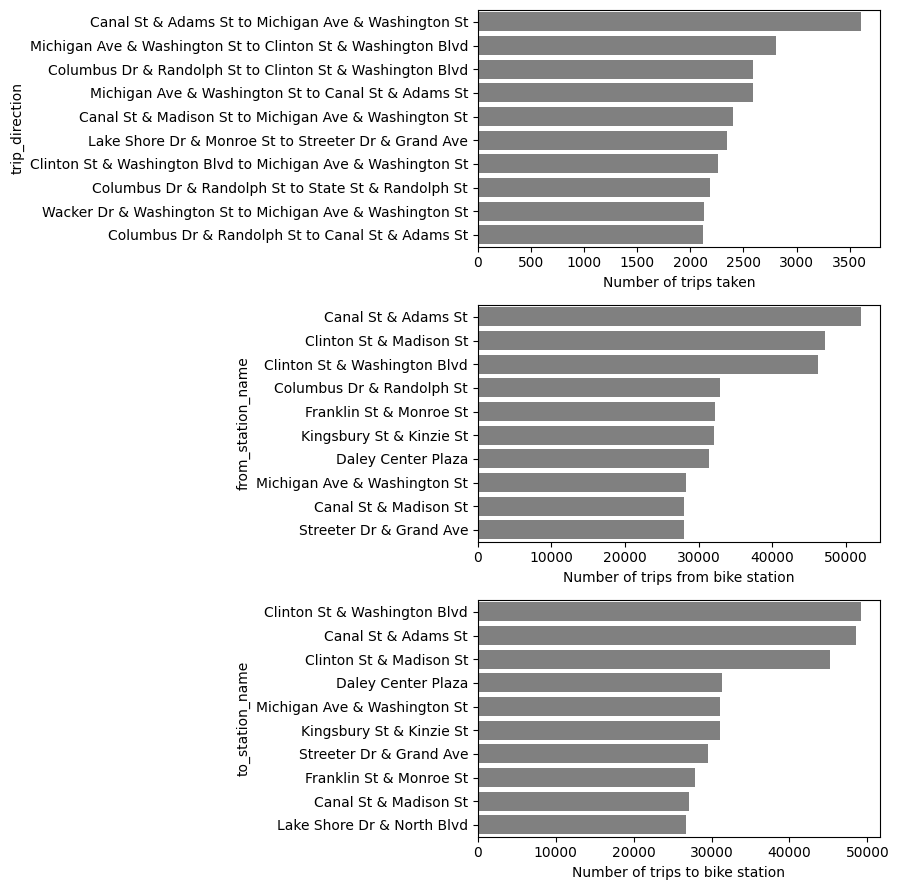

In [7]:
# Plot bar charts for top 10 popular trips and bike stations
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 9))

sns.barplot(data=popular_trips.head(10), x="count", y="trip_direction", color="grey", ax=ax1);
ax1.set_xlabel("Number of trips taken");
sns.barplot(data=popular_from.head(10), x="count", y="from_station_name", color="grey", ax=ax2)
ax2.set_xlabel("Number of trips from bike station");
sns.barplot(data=popular_to.head(10), x="count", y="to_station_name", color="grey", ax=ax3)
ax3.set_xlabel("Number of trips to bike station");

plt.tight_layout()

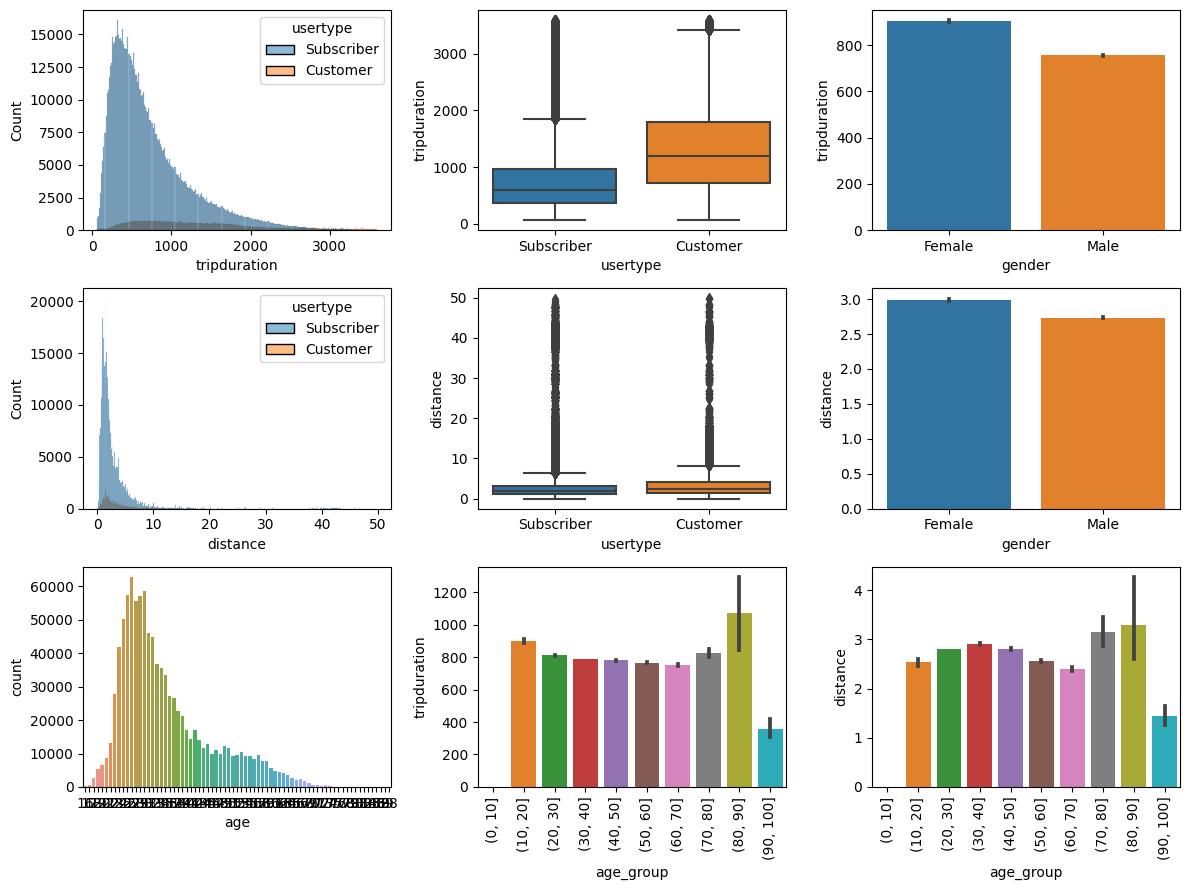

In [8]:
# Plot distributions of major_trips by usertype, gender and age

# Subset a million for plotting
plot_trips = major_trips.sample(1000000)

fig, axs = plt.subplots(3, 3, figsize=(12,9))

# By trip duration
sns.histplot(data=plot_trips, x="tripduration", hue="usertype", ax=axs[0,0]);
sns.boxplot(data=plot_trips, x="usertype", y="tripduration", ax=axs[0,1]);
sns.barplot(data=plot_trips, x="gender", y="tripduration", ax=axs[0,2]);

# By distance
sns.histplot(data=plot_trips, x="distance", hue="usertype", ax=axs[1,0]);
sns.boxplot(data=plot_trips, x="usertype", y="distance", ax=axs[1,1]);
sns.barplot(data=plot_trips, x="gender", y="distance", ax=axs[1,2]);

# Age and age group
age_df = (plot_trips["age"].value_counts()          
                           .reset_index()
                           .rename(columns={"index":"age",
                                            "age":"count"}))
sns.barplot(data=age_df, x="age", y="count", ax=axs[2,0])
sns.barplot(data=plot_trips, x="age_group", y="tripduration", ax=axs[2,1])
sns.barplot(data=plot_trips, x="age_group", y="distance", ax=axs[2,2])

axs[2,1].tick_params(axis="x", rotation=90)
axs[2,2].tick_params(axis="x", rotation=90)


plt.tight_layout()

## Observations from `usertype`, `gender` and `age` distributions
* Majority of trips ended before 3000 seconds (50 minutes).
* Subscription plan allows up to 45 minutes of free cycling, which explains why most trips by subscribers end before 50 minutes.
* Customers (ad-hoc riders) ride longer (duration and distance) than subscribers.
* Females ride longer (duration and distance) than males.
* Majority of riders' ages between 10-60.
* Odd spike in trip duration and distance in riders' age group at 70-90.
* Could be just a couple of riders taking frequent trips, but riders' id not available.

In [9]:
# Issue with age_groups > 70
major_trips[major_trips["age"] > 70]["age"].value_counts()

71    2283
73    1827
74     753
72     590
75     389
98     247
79     239
77     237
76     103
80      87
78      72
89      35
86      20
85      19
88      11
81      11
90       5
82       4
94       2
84       2
83       1
Name: age, dtype: int64

* Age 98 count number abnormally high -> inaccurate birthyear input from customers?

# Section 3: Trips durations and distances based on climate

In [10]:
# Group data set by day and average the trips' duration, distance and temperature of the day
group_day = (major_trips.groupby("date_list")
                        .agg(avg_temp = ("avg_temp", "mean"),
                             avg_duration = ("tripduration", "mean"),
                             avg_distance = ("distance", "mean"))
                        .reset_index())
group_day["date_list"] = group_day["date_list"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

In [11]:
# Split group day data into customers and subscribers to see if there's difference in their behaviors
# during different periods of the year

cuser_group = major_trips[major_trips["usertype"] == "Customer"]
cgroup_day = (cuser_group.groupby("date_list")
                         .agg(avg_temp = ("avg_temp", "mean"),
                              avg_duration = ("tripduration", "mean"),
                              avg_distance = ("distance", "mean"))
                         .reset_index())
cgroup_day["date_list"] = cgroup_day["date_list"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

suser_group = major_trips[major_trips["usertype"] == "Subscriber"]
sgroup_day = (suser_group.groupby("date_list")
                         .agg(avg_temp = ("avg_temp", "mean"),
                              avg_duration = ("tripduration", "mean"),
                              avg_distance = ("distance", "mean"))
                         .reset_index())
sgroup_day["date_list"] = sgroup_day["date_list"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

In [12]:
# Trips duration, distance and temperature over the year
def line_plot(data=None, x=None, 
              y1=None, y2=None, 
              y1_ylim=(-30,35),         # y1 axis temperature default
              y2_ylim=(0,1500),         # y2 axis duration default
              y1_label="", y2_label=""):
    
    fig, ax1 = plt.subplots()
    
    ax2 = ax1.twinx()       # dual axis chart
    
    # First plot
    ax1.plot(data[x], data[y1], color="indianred")
    ax1.set_ylabel(y1_label, color="indianred")
    ax1.tick_params(axis="y", labelcolor="indianred")
    ax1.set_ylim(y1_ylim[0], y1_ylim[1])

    # Second plot
    ax2.plot(data[x], data[y2], color="steelblue");
    ax2.set_ylabel(y2_label, color="steelblue")
    ax2.tick_params(axis="y", labelcolor="steelblue")
    ax2.set_ylim(y2_ylim[0], y2_ylim[1])
    
    ax1.xaxis.set_major_formatter(ticker.NullFormatter())
    ax2.xaxis.set_major_locator(mdates.MonthLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b"))

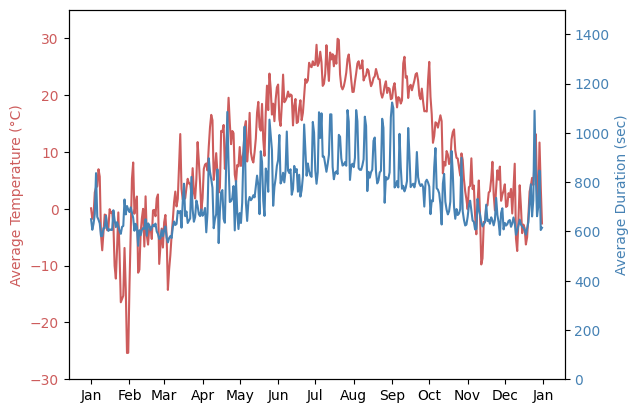

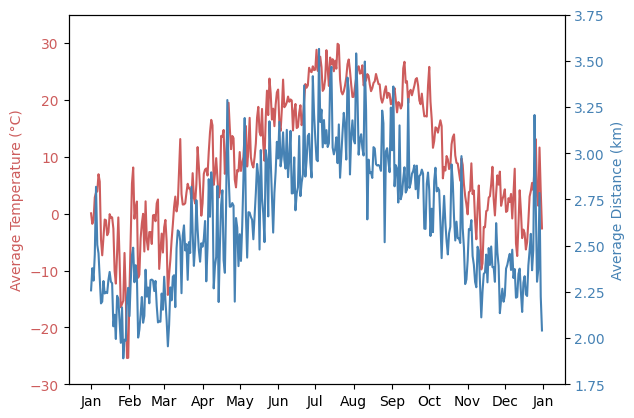

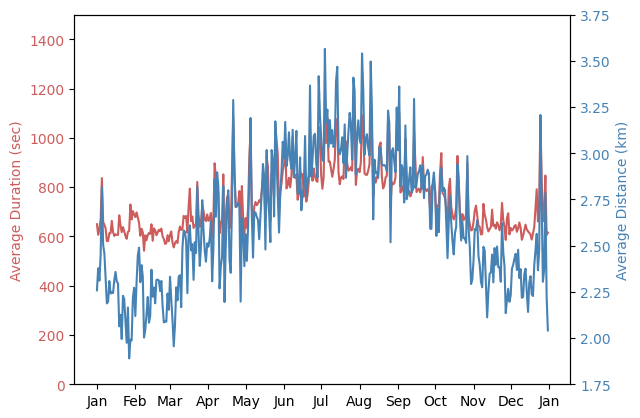

In [13]:
# (major_trips) Plot line charts of trip durations, distances and temperature of the day 
line_plot(data=group_day, 
          x="date_list", 
          y1="avg_temp", 
          y2="avg_duration",
          y1_label="Average Temperature (°C)",
          y2_label="Average Duration (sec)")

line_plot(data=group_day, 
          x="date_list", 
          y1="avg_temp", 
          y2="avg_distance",
          y2_ylim=(1.75, 3.75),
          y1_label="Average Temperature (°C)",
          y2_label="Average Distance (km)")

line_plot(data=group_day, 
          x="date_list", 
          y1="avg_duration", 
          y2="avg_distance",
          y1_ylim=(0,1500),
          y2_ylim=(1.75, 3.75),
          y1_label="Average Duration (sec)",
          y2_label="Average Distance (km)")

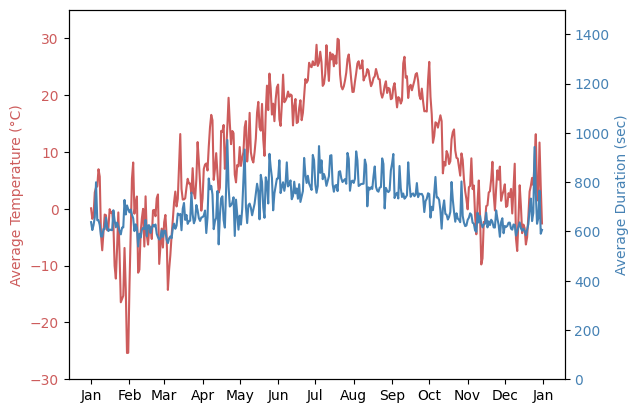

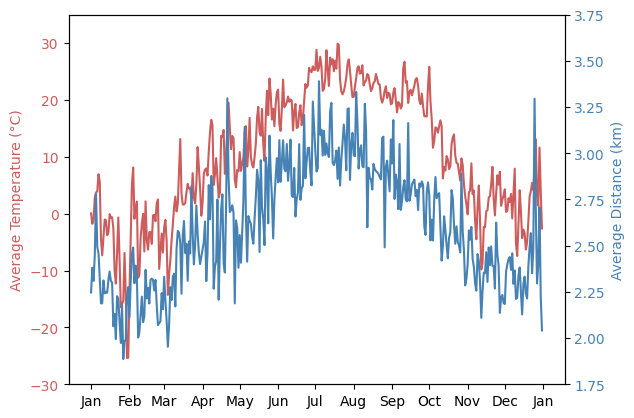

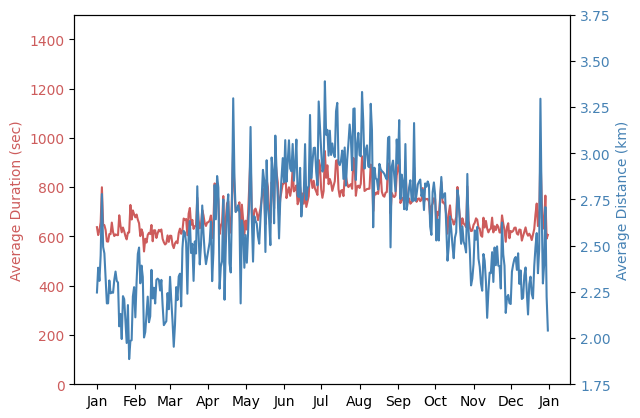

In [14]:
# (Subscribers) Plot line charts of trip durations, distances and temperature of the day 
line_plot(data=sgroup_day, 
          x="date_list", 
          y1="avg_temp", 
          y2="avg_duration",
          y1_label="Average Temperature (°C)",
          y2_label="Average Duration (sec)")

line_plot(data=sgroup_day, 
          x="date_list", 
          y1="avg_temp", 
          y2="avg_distance",
          y2_ylim=(1.75, 3.75),
          y1_label="Average Temperature (°C)",
          y2_label="Average Distance (km)")

line_plot(data=sgroup_day, 
          x="date_list", 
          y1="avg_duration", 
          y2="avg_distance",
          y1_ylim=(0,1500),
          y2_ylim=(1.75, 3.75),
          y1_label="Average Duration (sec)",
          y2_label="Average Distance (km)")

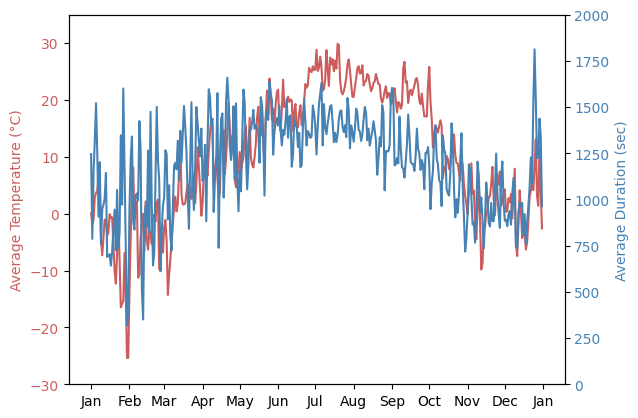

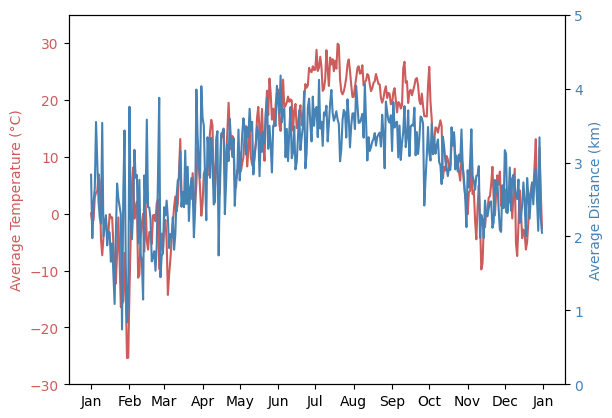

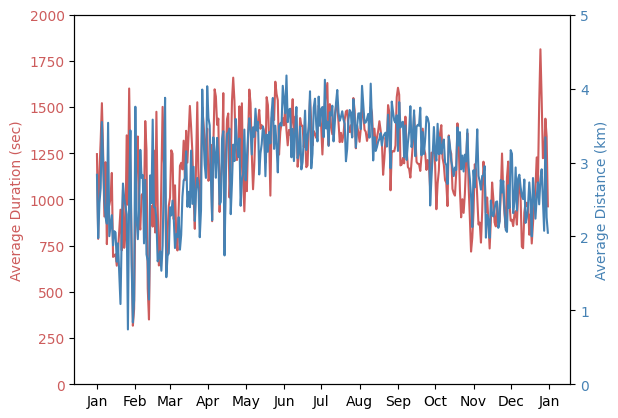

In [15]:
# (Customers) Plot line charts of trip durations, distances and temperature of the day
line_plot(data=cgroup_day, 
          x="date_list", 
          y1="avg_temp", 
          y2="avg_duration",
          y1_ylim=(-30,35),
          y2_ylim=(0,2000),
          y1_label="Average Temperature (°C)",
          y2_label="Average Duration (sec)")

line_plot(data=cgroup_day, 
          x="date_list", 
          y1="avg_temp", 
          y2="avg_distance",
          y1_ylim=(-30,35),
          y2_ylim=(0,5),
          y1_label="Average Temperature (°C)",
          y2_label="Average Distance (km)")

line_plot(data=cgroup_day, 
          x="date_list", 
          y1="avg_duration", 
          y2="avg_distance",
          y1_ylim=(0,2000),
          y2_ylim=(0,5),
          y1_label="Average Duration (sec)",
          y2_label="Average Distance (km)")

## Observations for durations and distances based on climate
* The trip durations and distances match the climate of the year quite closely.
* Rides are shorter in duration and distance during the winter periods (Nov-Mar), and are longer during the summar period (Jun-Sep).
* When segregated by usertype, customers' rides still match the climate of the closely.
* For subscribers, trip durations don't fluctuate much throughout the year, but trips are generally shorter in winter period and longer in the summer period.
* Subscribers ride slower in winter period than in summer period. 

# Section 4: Mapping stations and trips onto openboxmap

In [16]:
# Filtering out the geocodes of popular stations
from_unique_stations = major_trips[~major_trips.duplicated("from_station_name")]
to_unique_stations = major_trips[~major_trips.duplicated("to_station_name")]

popular_from_geocode = pd.merge(left=popular_from.head(5), 
                                right=from_unique_stations[["from_station_name", "from_lat", "from_lng", "to_lat", "to_lng"]],
                                how="left",
                                left_on="from_station_name",
                                right_on="from_station_name")
popular_to_geocode = pd.merge(left=popular_to.head(5), 
                              right=to_unique_stations[["to_station_name", "from_lat", "from_lng", "to_lat", "to_lng"]],
                              how="left",
                              left_on="to_station_name",
                              right_on="to_station_name")


# Filtering out the geocodes of popular trips
unique_trips = major_trips[~major_trips.duplicated("trip_direction")]

popular_trips_geocode = pd.merge(left=popular_trips.head(5), 
                                 right=unique_trips[["trip_direction", "from_lat", "from_lng", "to_lat", "to_lng"]],
                                 how="left",
                                 left_on="trip_direction",
                                 right_on="trip_direction")

In [17]:
# Open street map showing most popular stations and trips
# Initiate map
fig = go.Figure(layout=go.Layout(mapbox_style="open-street-map"));

# Most popular from stations
from_trace = go.Scattermapbox(lat=popular_from_geocode["from_lat"],
                              lon=popular_from_geocode["from_lng"],
                              mode="markers",
                              marker = {"color": "indianred",
                                        "size": 12},
                              hoverinfo="text",
                              hovertext=popular_from_geocode["from_station_name"]);

fig.add_trace(from_trace);

fig.update_layout(
    margin ={'l':5,'t':5,'b':5,'r':5},
    mapbox = {
        'center': {'lat': popular_from_geocode["from_lat"][0], 
                   'lon': popular_from_geocode["from_lng"][0]},
        'zoom': 13});

fig.show();

In [18]:
# Initiate map
fig = go.Figure(layout=go.Layout(mapbox_style="open-street-map"));

# Most popular to stations
to_trace = go.Scattermapbox(lat=popular_to_geocode["to_lat"],
                            lon=popular_to_geocode["to_lng"],
                            mode="markers",
                            marker = {"color": "steelblue",
                                      "size": 12},
                            hoverinfo="text",
                            hovertext=popular_to_geocode["to_station_name"]);
fig.add_trace(to_trace);
fig.update_layout(
    margin ={'l':5,'t':5,'b':5,'r':5},
    mapbox = {
        'center': {'lat': popular_from_geocode["to_lat"][0], 
                   'lon': popular_from_geocode["to_lng"][0]},
        'zoom': 13});

fig.show();

In [19]:
# Most popular trips
fig = go.Figure(layout=go.Layout(mapbox_style="open-street-map"));

fig.add_trace(go.Scattermapbox(mode="markers+lines",
                               lat=[popular_trips_geocode["from_lat"][0], popular_trips_geocode["to_lat"][0]],
                               lon=[popular_trips_geocode["from_lng"][0], popular_trips_geocode["to_lng"][0]],
                               marker = {"color": "indianred",
                                        "size": 12},
                               hoverinfo="text",
                               hovertext=popular_trips_geocode["trip_direction"][0]))

fig.update_layout(
    margin ={'l':5,'t':5,'b':5,'r':5},
    mapbox = {
        'center': {'lat': popular_trips_geocode["from_lat"][0], 
                   'lon': popular_trips_geocode["from_lng"][0]},
        'zoom': 13});

fig.show();